# Load libraries

In [3]:
import numpy as np
import pandas as pd
import os
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

import warnings
warnings.filterwarnings("ignore")

print("Load Models")

Load Models


# Read Data

In [4]:
train_dir = "/kaggle/input/skin-cancer-malignant-vs-benign/train"

filepaths = []
labels = []

folds = os.listdir(train_dir)

for fold in folds:
    foldpaths = os.path.join(train_dir, fold)
    filelists = os.listdir(foldpaths)
    
    for file in filelists:
        filepath= os.path.join(foldpaths, file)
        
        filepaths.append(filepath)
        labels.append(fold)
        
Fseries = pd.Series(filepaths, name= 'Filepath')
Lseries = pd.Series(labels, name='Label')

train_df = pd.concat([Fseries, Lseries], axis=1)
train_df.head()

,Filepath,Label
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign


In [5]:
test_dir = "/kaggle/input/skin-cancer-malignant-vs-benign/test"

filepaths = []
labels = []

folds = os.listdir(test_dir)

for fold in folds:
    foldpaths = os.path.join(test_dir, fold)
    filelists = os.listdir(foldpaths)
    
    for file in filelists:
        filepath= os.path.join(foldpaths, file)
        
        filepaths.append(filepath)
        labels.append(fold)
        
Fseries = pd.Series(filepaths, name= 'Filepath')
Lseries = pd.Series(labels, name='Label')

dummy_df = pd.concat([Fseries, Lseries], axis=1)
dummy_df.head()

,Filepath,Label
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign


In [6]:
valid_df, test_df = train_test_split(dummy_df, test_size=0.5, shuffle= True, random_state= 42,
                                    stratify= dummy_df['Label'])


# Data Preprocessing

In [7]:
batch_size = 10
image_size = (224,224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col="Filepath", y_col="Label",
                                   class_mode ="categorical", color="rgb",
                                   batch_size= batch_size, target_size = image_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col="Filepath", y_col="Label",
                                   class_mode ="categorical", color="rgb",
                                   batch_size= batch_size, target_size = image_size)

test_gen = gen.flow_from_dataframe(test_df, x_col="Filepath", y_col="Label",
                                   class_mode ="categorical", color="rgb",
                                   batch_size= batch_size, target_size = image_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


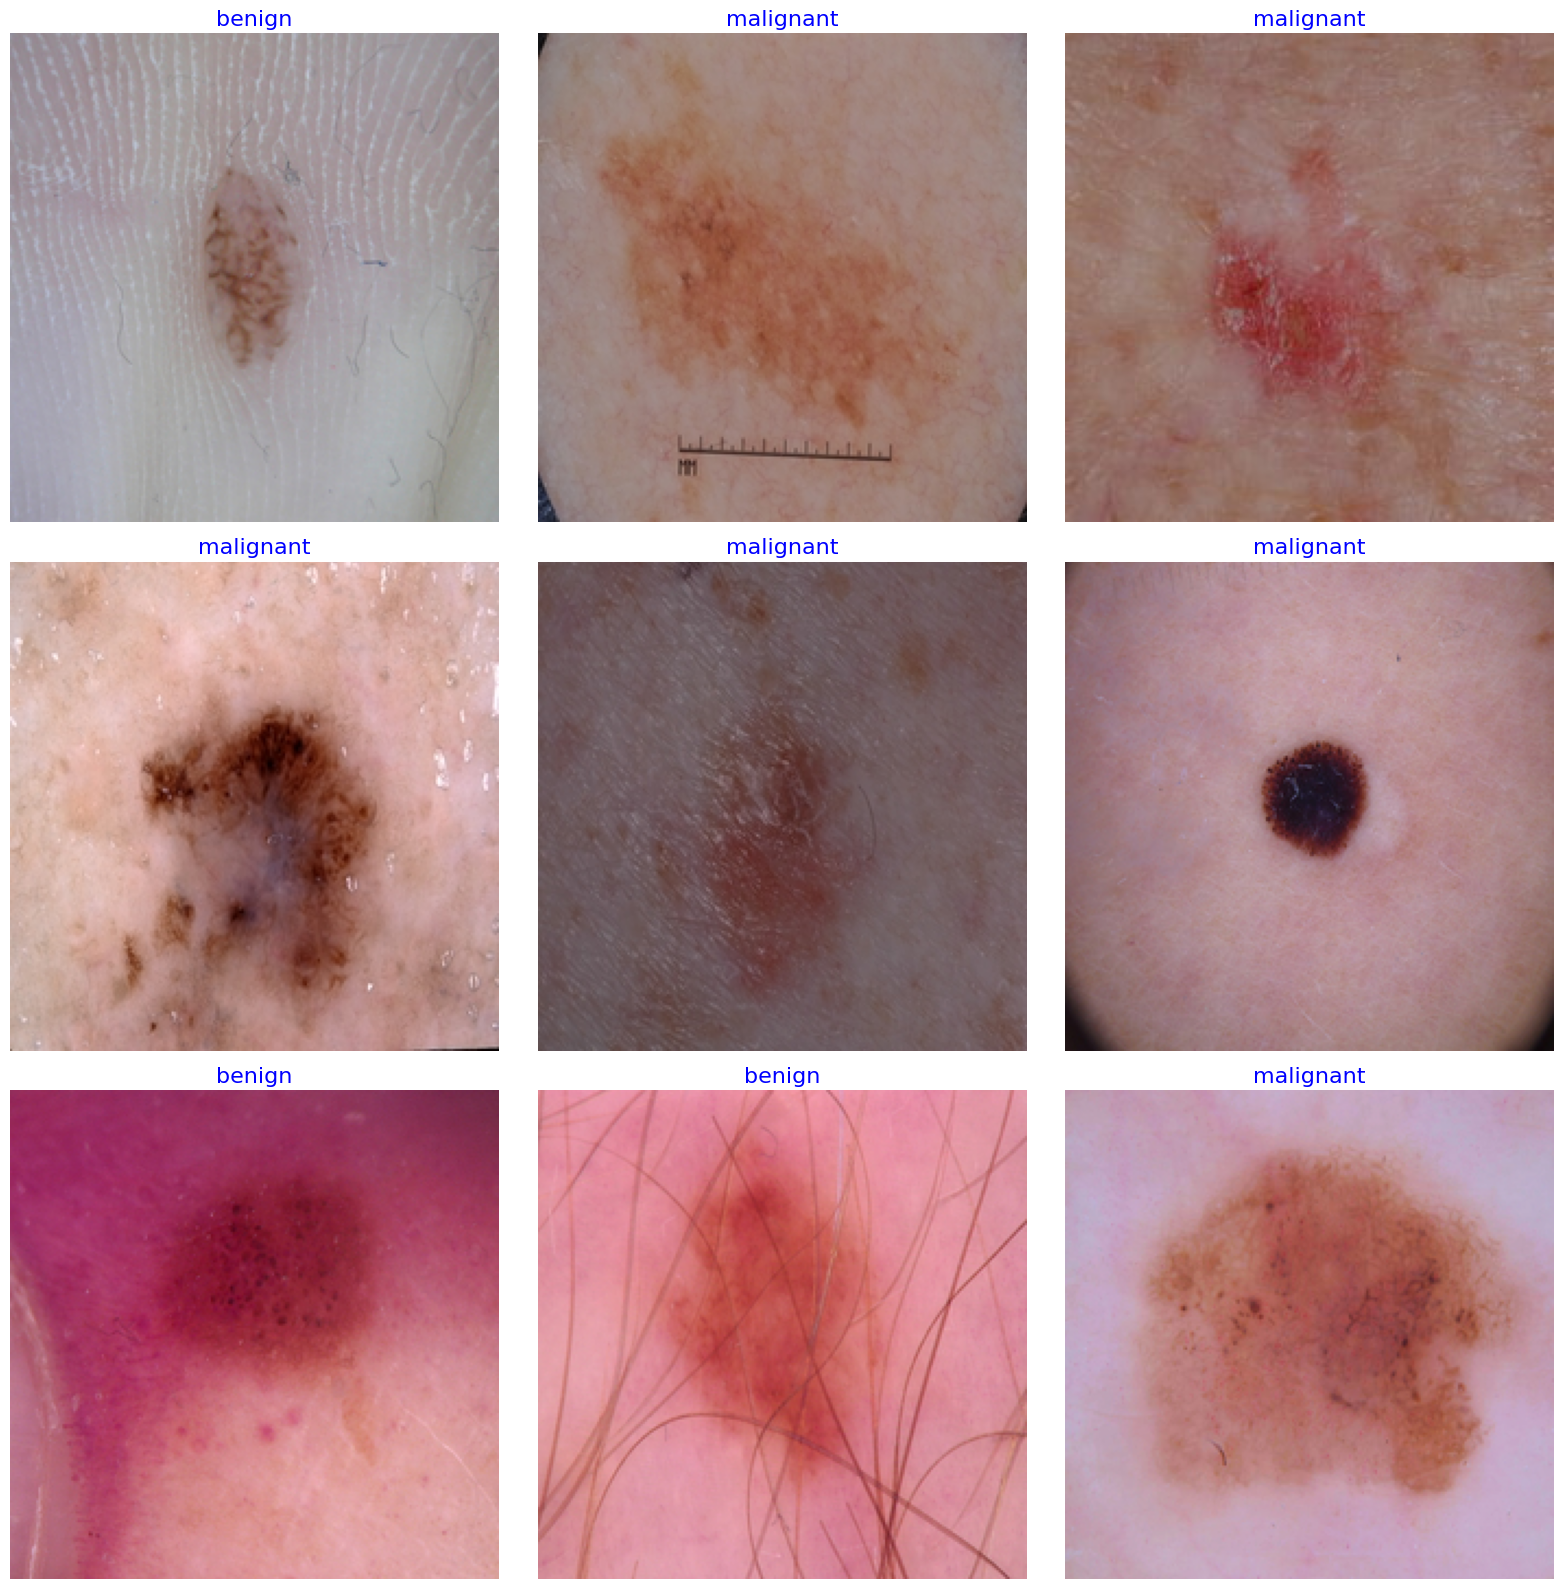

In [6]:
gen_dict = train_gen.class_indices
classes_name = list(gen_dict.keys())

images, labels = next(train_gen)


plt.figure(figsize= (16, 16))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes_name[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# CNN model structure

In [29]:
channels = 3
image_size = (224,224)
image_shape =(image_size[0], image_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters= 32, kernel_size = (3,3), padding='same', activation = 'relu', input_shape = image_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters= 64, kernel_size = (3,3), padding='same', activation = 'relu'),
    Conv2D(filters= 64, kernel_size = (3,3), padding='same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters = 128 , kernel_size = (3,3) , padding='same', activation='relu'),
    Conv2D(filters = 128 , kernel_size = (3,3) , padding='same', activation='relu'),
    Conv2D(filters = 128 , kernel_size = (3,3) , padding='same', activation='relu'),
    Dropout(rate=0.2),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters = 256 , kernel_size = (3,3) , padding='same', activation='relu'),
    Conv2D(filters = 256 , kernel_size = (3,3) , padding='same', activation='relu'),
    Conv2D(filters = 256 , kernel_size = (3,3) , padding='same', activation='relu'),
    Dropout(rate=0.2),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters = 512 , kernel_size = (3,3) , padding='same', activation='relu'),
    Conv2D(filters = 512 , kernel_size = (3,3) , padding='same', activation='relu'),
    Conv2D(filters = 512 , kernel_size = (3,3) , padding='same', activation='relu'),
    Dropout(rate=0.3),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    BatchNormalization(),
    
    Dense(512, activation="relu"),
    Dropout(rate=0.3),
    Dense(256, activation="relu"),
    Dropout(rate=0.3),
    Dense(128, activation="relu"),
    Dropout(rate=0.45),
    Dense(class_count, activation="softmax")
])

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 14, 14, 512)    │             

 Total params: 20,912,770 (79.78 MB)

 Trainable params: 20,861,634 (79.58 MB)

 Non-trainable params: 51,136 (199.75 KB)

In [30]:
history = model.fit(train_gen, epochs= 30, verbose= 1,
                    validation_data = valid_gen, shuffle= False)

Epoch 1/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - accuracy: 0.6008 - loss: 3.1429 - val_accuracy: 0.6212 - val_loss: 1.4099
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.6580 - loss: 1.4157 - val_accuracy: 0.6727 - val_loss: 0.5830
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7023 - loss: 1.1105 - val_accuracy: 0.7545 - val_loss: 0.4737
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.6815 - loss: 0.9835 - val_accuracy: 0.6576 - val_loss: 0.6153
Epoch 5/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.6906 - loss: 0.8397 - val_accuracy: 0.6788 - val_loss: 0.5916
Epoch 6/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.6898 - loss: 0.6980 - val_accuracy: 0.7606 - val_loss: 0.5036
Epoch 7/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7238 - loss: 0.6219 - val_accuracy: 0.7364 - val_loss: 0.4940
Epoch 8/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7141 - loss: 0.6525 - 

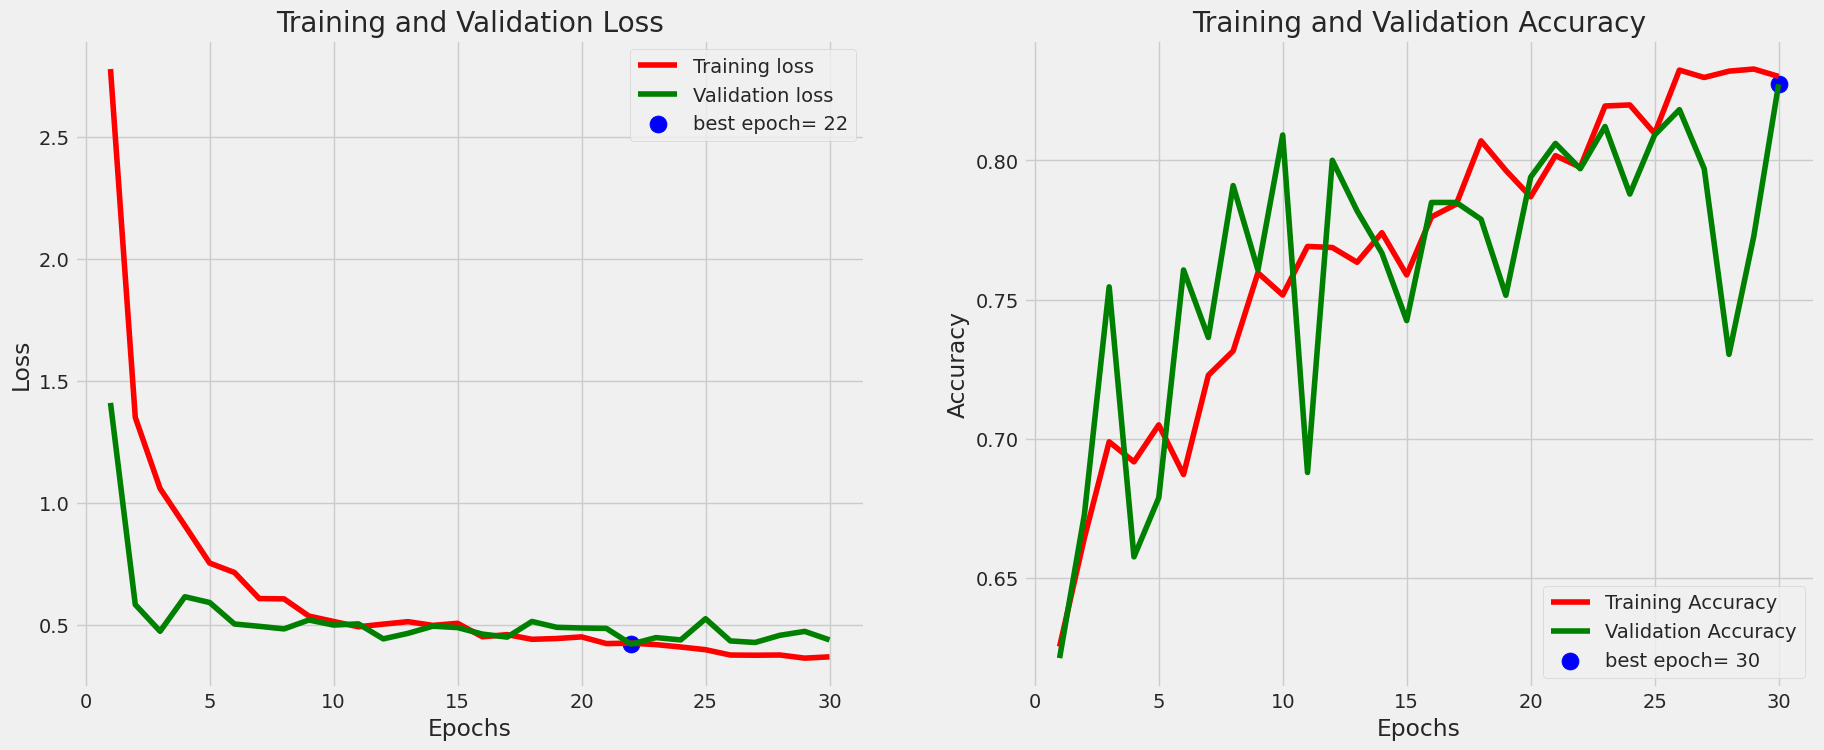

In [31]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate the CNN model

In [32]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

264/264 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8542 - loss: 0.3815
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8461 - loss: 0.4238
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8772 - loss: 0.3551
Train Loss:  0.37823963165283203
Train Accuracy:  0.8570345044136047
--------------------
Validation Loss:  0.4384026825428009
Validation Accuracy:  0.8272727131843567
--------------------
Test Loss:  0.3571148216724396
Test Accuracy:  0.8818181753158569


In [33]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1) 

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


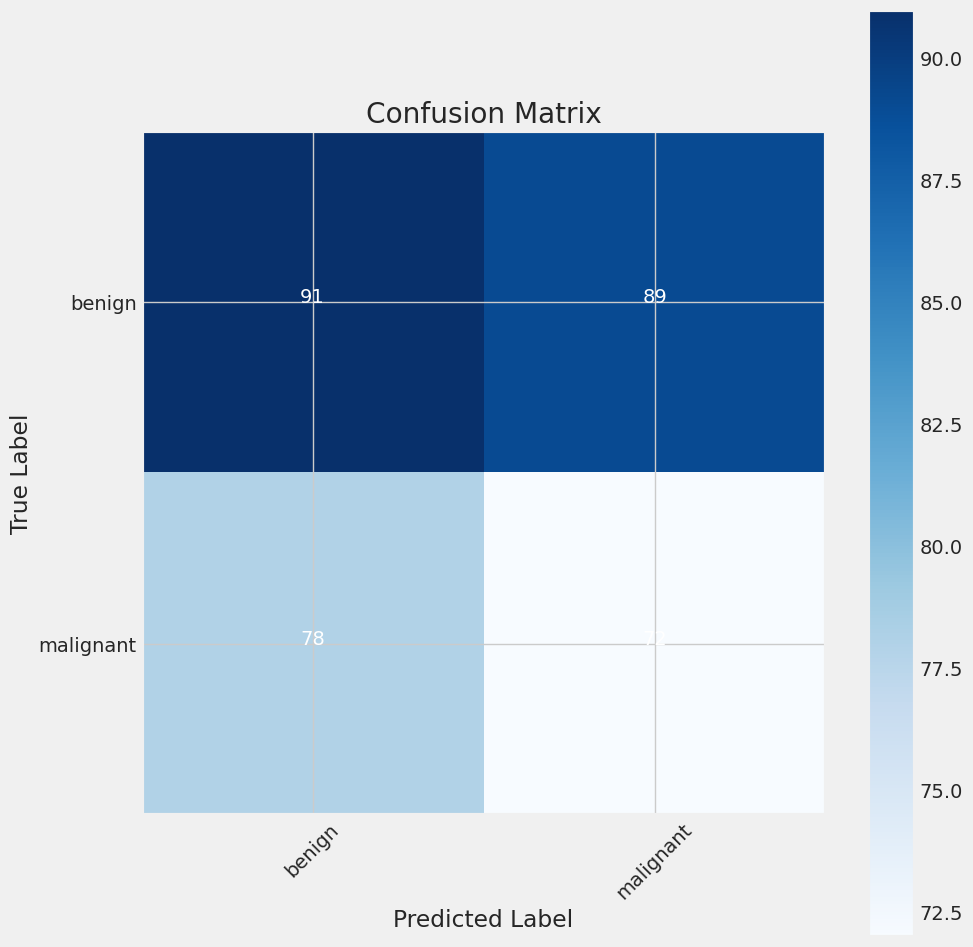

In [34]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center',
             color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [35]:
print(classification_report(test_gen.classes, y_pred,
                            target_names= classes))

              precision    recall  f1-score   support

      benign       0.54      0.51      0.52       180
   malignant       0.45      0.48      0.46       150

    accuracy                           0.49       330
   macro avg       0.49      0.49      0.49       330
weighted avg       0.50      0.49      0.49       330



# Save the CNN model

In [36]:
model.save('model.h5')

# Use pretrained model EfficientNetB7

In [8]:
channels = 3
image_size = (224,224)
image_shape =(image_size[0], image_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model_base= keras.applications.EfficientNetB7(
    include_top = False,
    weights= "imagenet",
    input_shape= image_shape,
    pooling = 'avg'
)

model_base.trainable = False 

model2 = Sequential([
    model_base,
    #Flatten(),
    BatchNormalization(),
 
    Dense(512, activation="relu"),
    Dense(128, activation="relu"),
    Dropout(rate=0.5, seed=123),
    Dense(64, activation="relu"),
    Dense(class_count, activation="softmax")
])

model2.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.build(input_shape=(None, *image_shape))
model2.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 2560)           │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,493,209 (249.84 MB)

 Trainable params: 1,390,402 (5.30 MB)

 Non-trainable params: 64,102,807 (244.53 MB)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model2.fit(train_gen, epochs= 30, verbose= 1,
                    validation_data = valid_gen, shuffle= True)

Epoch 1/30
  1/264 ━━━━━━━━━━━━━━━━━━━━ 10:07:37 139s/step - accuracy: 0.7000 - loss: 0.6487

I0000 00:00:1721761568.491207     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721761568.676093     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.6606 - loss: 0.6383

W0000 00:00:1721761729.107826     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


264/264 ━━━━━━━━━━━━━━━━━━━━ 302s 621ms/step - accuracy: 0.6607 - loss: 0.6380 - val_accuracy: 0.7879 - val_loss: 0.4847
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.7604 - loss: 0.4830 - val_accuracy: 0.7970 - val_loss: 0.3889
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.8043 - loss: 0.4287 - val_accuracy: 0.8091 - val_loss: 0.3734
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.7843 - loss: 0.4212 - val_accuracy: 0.8121 - val_loss: 0.3638
Epoch 5/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.8035 - loss: 0.4043 - val_accuracy: 0.8242 - val_loss: 0.3479
Epoch 6/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.8218 - loss: 0.3756 - val_accuracy: 0.8303 - val_loss: 0.3464
Epoch 7/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.8332 - loss: 0.3614 - val_accuracy: 0.8212 - val_loss: 0.3390
Epoch 8/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.8342 - loss: 0.3615 - val_accur

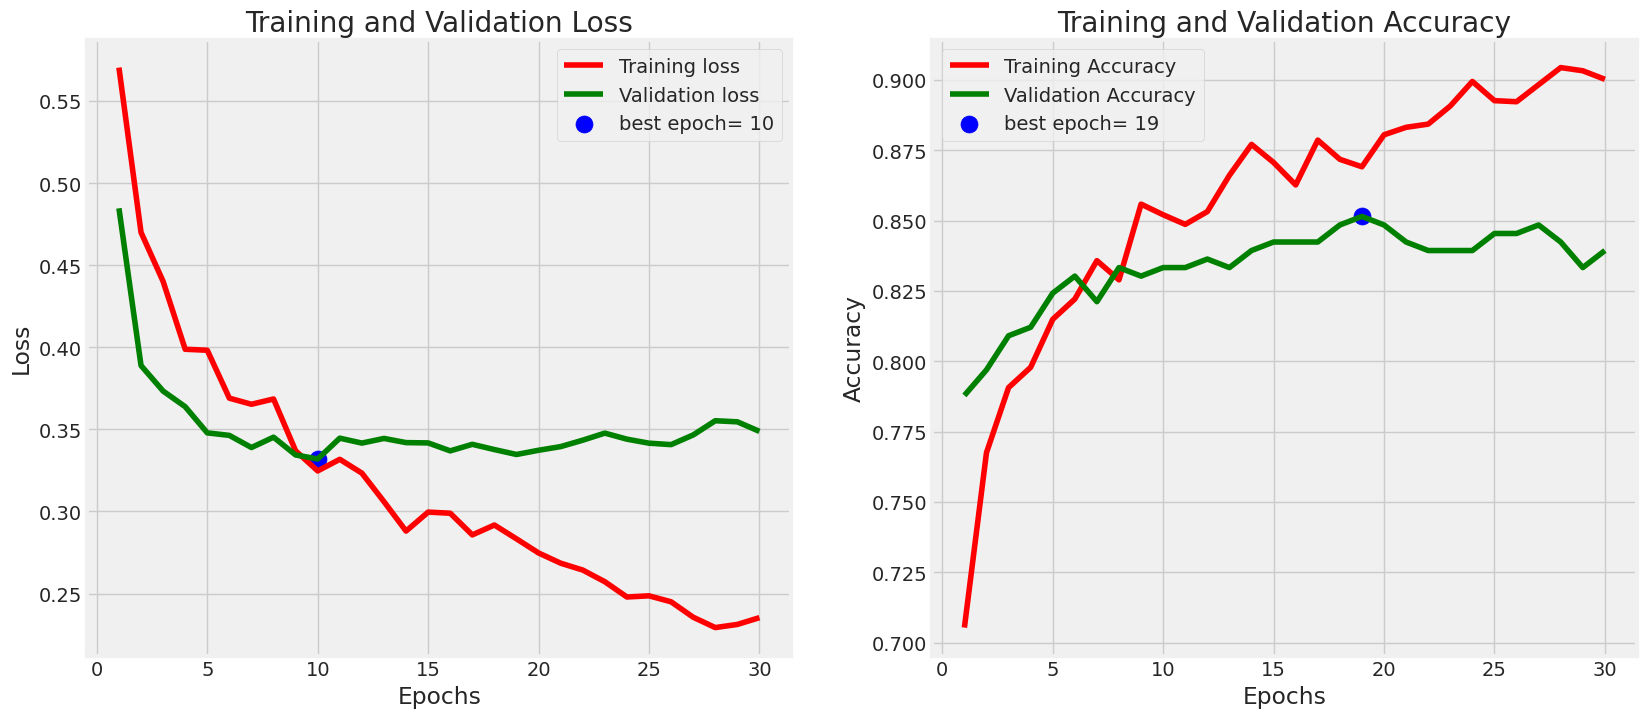

In [11]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [12]:
train_score = model2.evaluate(train_gen, verbose= 1)
valid_score = model2.evaluate(valid_gen, verbose= 1)
test_score = model2.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

264/264 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - accuracy: 0.9646 - loss: 0.1054
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.8516 - loss: 0.3353
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.8971 - loss: 0.3050
Train Loss:  0.10338102281093597
Train Accuracy:  0.9670079350471497
--------------------
Validation Loss:  0.34880614280700684
Validation Accuracy:  0.8393939137458801
--------------------
Test Loss:  0.27118924260139465
Test Accuracy:  0.8999999761581421


# Use pretrained model VGG16

In [31]:
channels = 3
image_size = (224,224)
image_shape =(image_size[0], image_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model_base= keras.applications.VGG16(
    include_top = False,
    weights= "imagenet",
    input_shape= image_shape,
    pooling = 'avg'
)

model_base.trainable = False 

model2 = Sequential([
    model_base,
    #Flatten(),
    BatchNormalization(),
 
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dropout(rate=0.3, seed=123),
    Dense(class_count, activation="softmax")
])

model2.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.build(input_shape=(None, *image_shape))
model2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,143,874 (57.77 MB)

 Trainable params: 428,162 (1.63 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model2.fit(train_gen, epochs= 30, verbose= 1,
                    validation_data = valid_gen, shuffle= True)

Epoch 1/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.7164 - loss: 0.5683 - val_accuracy: 0.8000 - val_loss: 0.4352
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7921 - loss: 0.4435 - val_accuracy: 0.8061 - val_loss: 0.4676
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7895 - loss: 0.4340 - val_accuracy: 0.7848 - val_loss: 0.4600
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7926 - loss: 0.4296 - val_accuracy: 0.8000 - val_loss: 0.4546
Epoch 5/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7993 - loss: 0.4177 - val_accuracy: 0.7939 - val_loss: 0.4258
Epoch 6/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.8152 - loss: 0.3862 - val_accuracy: 0.8061 - val_loss: 0.4007
Epoch 7/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8007 - loss: 0.4092 - val_accuracy: 0.8152 - val_loss: 0.4233
Epoch 8/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.8185 - loss: 0.3923 - val_acc

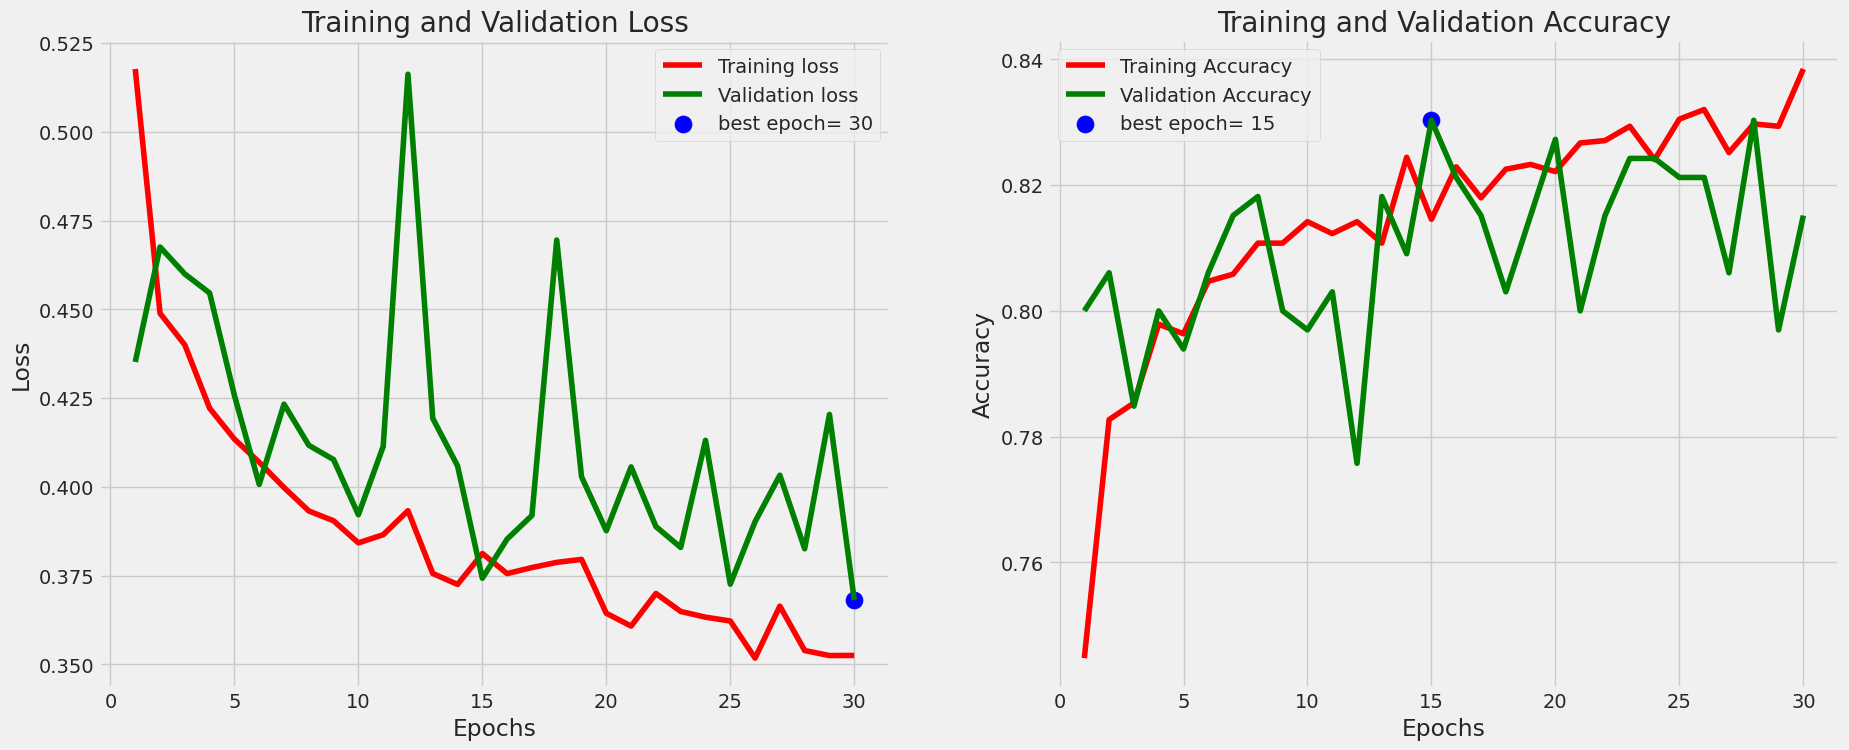

In [33]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [35]:
train_score = model2.evaluate(train_gen, verbose= 1)
valid_score = model2.evaluate(valid_gen, verbose= 1)
test_score = model2.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

264/264 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.8617 - loss: 0.3249
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8301 - loss: 0.3484
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.8803 - loss: 0.3140
Train Loss:  0.42695122957229614
Train Accuracy:  0.852483868598938
--------------------
Validation Loss:  0.3681645095348358
Validation Accuracy:  0.8151515126228333
--------------------
Test Loss:  0.3182491064071655
Test Accuracy:  0.8848484754562378


# Use pretrained model ResNet50

In [25]:
channels = 3
image_size = (224,224)
image_shape =(image_size[0], image_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model_base= keras.applications.ResNet50(
    include_top = False,
    weights= "imagenet",
    input_shape= image_shape,
    pooling = 'max'
)

model_base.trainable = False 

model3 = Sequential([
    model_base,
    #Flatten(),
    BatchNormalization(),
    
    Dense(512, activation="relu"),
    Dropout(rate=0.5, seed=123),
    Dense(256, activation="relu"),
    Dropout(rate=0.5, seed=123),
    Dense(128, activation="relu"),
    Dropout(rate=0.3, seed=123),
    Dense(class_count, activation="softmax")
])

model3.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['accuracy'])

model3.build(input_shape=(None, *image_shape))
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,809,474 (94.64 MB)

 Trainable params: 1,217,666 (4.65 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model3.fit(train_gen, epochs= 32, verbose= 1,
                    validation_data = valid_gen, shuffle= True)

Epoch 1/32
264/264 ━━━━━━━━━━━━━━━━━━━━ 39s 80ms/step - accuracy: 0.5632 - loss: 1.0850 - val_accuracy: 0.7697 - val_loss: 0.4727
Epoch 2/32
264/264 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.6433 - loss: 0.7966 - val_accuracy: 0.8030 - val_loss: 0.4274
Epoch 3/32
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.7117 - loss: 0.6766 - val_accuracy: 0.8061 - val_loss: 0.4112
Epoch 4/32
264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7349 - loss: 0.6095 - val_accuracy: 0.8091 - val_loss: 0.3927
Epoch 5/32
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7633 - loss: 0.5419 - val_accuracy: 0.8152 - val_loss: 0.3856
Epoch 6/32
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7719 - loss: 0.5410 - val_accuracy: 0.8152 - val_loss: 0.3805
Epoch 7/32
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7865 - loss: 0.5064 - val_accuracy: 0.8182 - val_loss: 0.3759
Epoch 8/32
264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.7833 - loss: 0.5054 - val_a

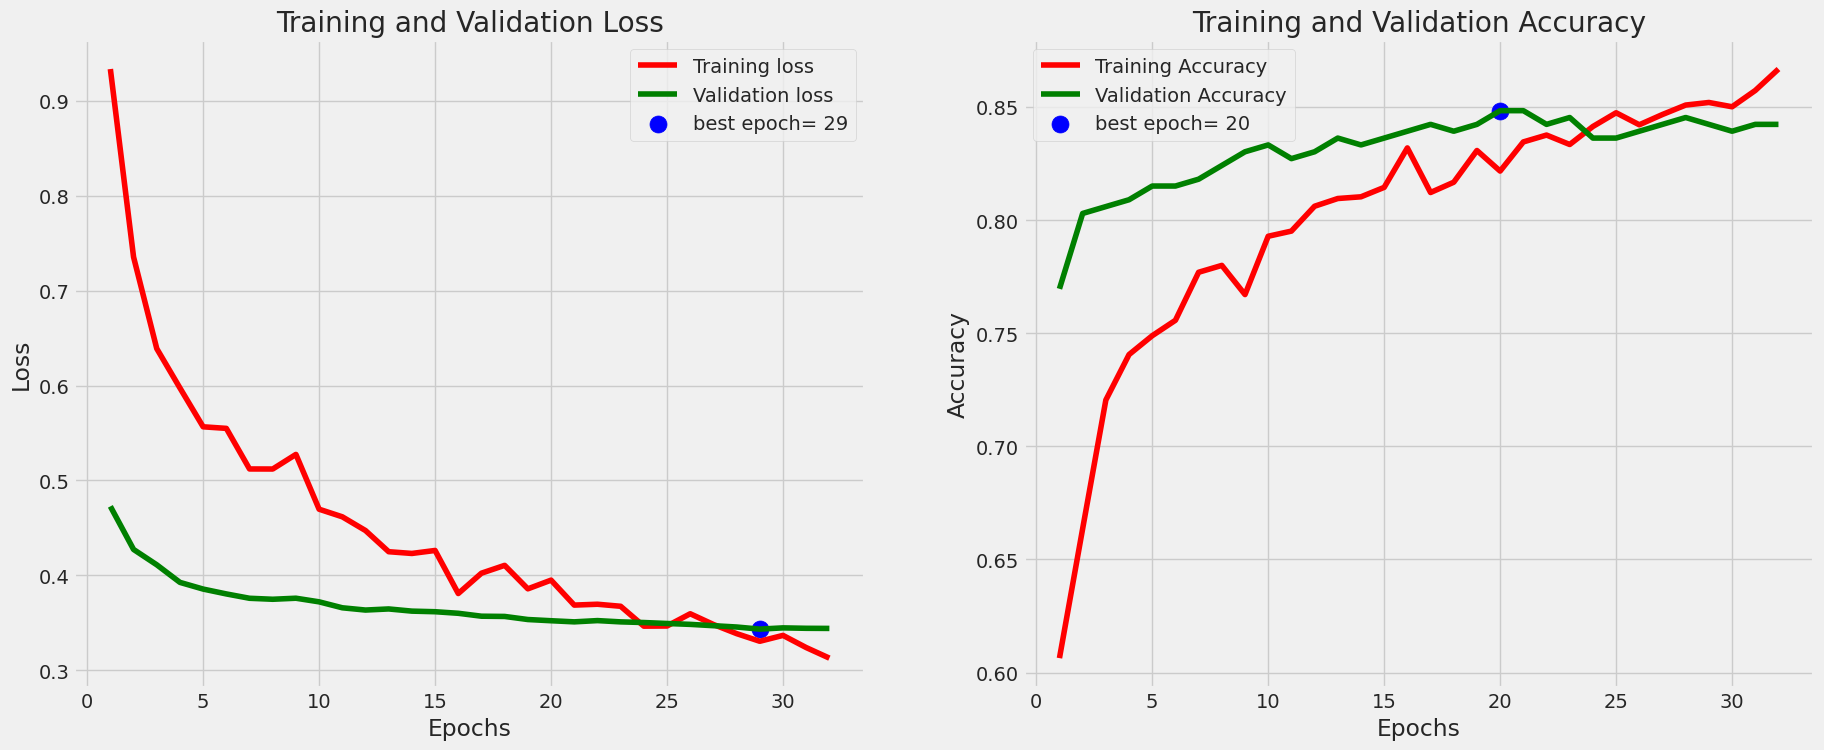

In [27]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [28]:
train_score = model3.evaluate(train_gen, verbose= 1)
valid_score = model3.evaluate(valid_gen, verbose= 1)
test_score = model3.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

264/264 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9275 - loss: 0.1865
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8545 - loss: 0.3590
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8674 - loss: 0.2759
Train Loss:  0.19035892188549042
Train Accuracy:  0.9237770438194275
--------------------
Validation Loss:  0.34417691826820374
Validation Accuracy:  0.842424213886261
--------------------
Test Loss:  0.24763290584087372
Test Accuracy:  0.8909090757369995


In [29]:
preds = model3.predict(test_gen)
y_pred = np.argmax(preds,axis=1)

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step


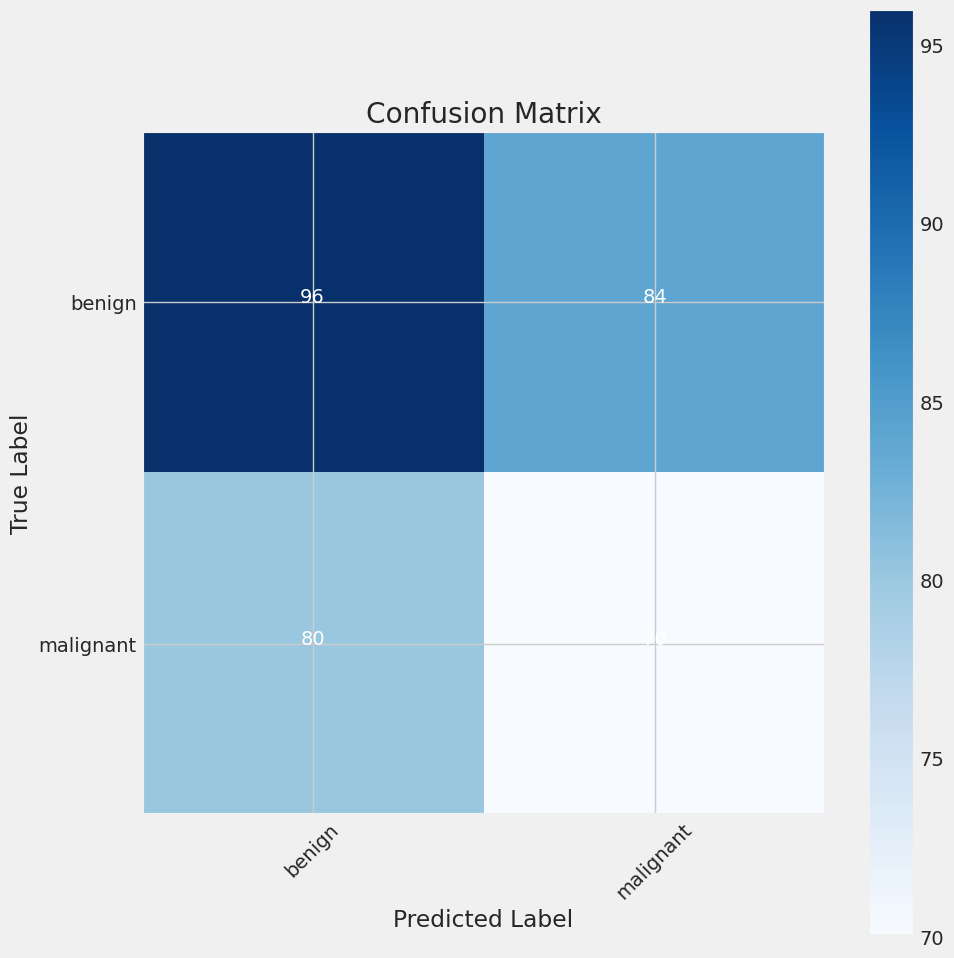

In [30]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center',
             color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()